In [ ]:
###############################################################################
# STEP A: MOUNT DRIVE & UNZIP
###############################################################################
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os

# Example: your zipped data is in Google Drive at /content/drive/MyDrive/Agri.zip
zip_path = '/content/drive/MyDrive/Colab Notebooks/Agri.zip'  # <-- ADAPT THIS
output_dir = '/content/data_unzipped'         # local unzipped folder

# Create local dir if needed
os.makedirs(output_dir, exist_ok=True)

# Unzip quietly (-q), overwriting if needed
!unzip -q "{zip_path}" -d "{output_dir}"

print("Data unzipped to:", output_dir)

Data unzipped to: /content/data_unzipped


In [ ]:
###############################################################################
# STEP B: INSTALLS & IMPORTS
###############################################################################
!pip install -q rasterio albumentations==1.3.0 scikit-learn

import re
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2

import rasterio
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

import albumentations as A

print("\nAll libraries imported successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 93.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 8.5 MB/s eta 0:00:00

All libraries imported successfully!


In [ ]:
###############################################################################
# STEP C: UTILITY FUNCTIONS (GROUP, READ, REMOVE BORDERS, CLUSTER, NDVI)
###############################################################################
def group_tif_files_by_image_id(folder):
    all_tifs = [f for f in os.listdir(folder) if f.lower().endswith('.tif')]
    all_tifs.sort()
    pattern = r"(IMG_\d+)_(\d+)\.tif"
    grouped = {}

    for filename in all_tifs:
        match = re.match(pattern, filename)
        if match:
            img_id = match.group(1)  # e.g. "IMG_0001"
            if img_id not in grouped:
                grouped[img_id] = []
            grouped[img_id].append(filename)

    for img_id, file_list in grouped.items():
        file_list.sort(key=lambda x: int(re.match(pattern, x).group(2)))
    return grouped

def read_5band_stack(folder, file_list):
    band_arrays = []
    for tif_file in file_list:
        path = os.path.join(folder, tif_file)
        with rasterio.open(path) as src:
            band_arrays.append(src.read(1))  # shape: (H, W)
    band_stack = np.stack(band_arrays, axis=0)  # => (5,H,W)
    return band_stack

def remove_black_borders(band_stack):
    non_zero_mask = np.any(band_stack != 0, axis=0)  # shape (H,W)
    rows = np.any(non_zero_mask, axis=1)
    cols = np.any(non_zero_mask, axis=0)
    if not np.any(rows) or not np.any(cols):
        return band_stack
    rmin, rmax = np.where(rows)[0][0], np.where(rows)[0][-1]
    cmin, cmax = np.where(cols)[0][0], np.where(cols)[0][-1]
    cropped = band_stack[:, rmin:rmax+1, cmin:cmax+1]
    return cropped

def kmeans_cluster(band_stack, n_clusters=3):
    C,H,W = band_stack.shape
    flat_data = band_stack.reshape(C, -1).T  # (H*W, C)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(flat_data)
    cluster_map = labels.reshape(H, W)
    return cluster_map

def compute_ndvi(band_stack, red_idx=2, nir_idx=4):
    red = band_stack[red_idx].astype(np.float32)
    nir = band_stack[nir_idx].astype(np.float32)
    with np.errstate(divide='ignore', invalid='ignore'):
        ndvi = (nir - red) / (nir + red + 1e-6)
        ndvi = np.nan_to_num(ndvi, nan=0.0, posinf=0.0, neginf=0.0)
    return ndvi

def generate_pseudo_mask(ndvi, threshold=0.3):
    mask = (ndvi >= threshold).astype(np.uint8)
    return mask

def combine_bands_clusters_ndvi(band_stack, cluster_map, ndvi):
    C,H,W = band_stack.shape  # 5
    out = np.zeros((C+2, H, W), dtype=np.float32)
    out[:C] = band_stack
    out[C] = cluster_map.astype(np.float32)
    out[C+1] = ndvi
    return out



In [ ]:
###############################################################################
# STEP D: PLOT ONE SAMPLE ONLY
###############################################################################
def show_one_sample(band_stack, cluster_map, ndvi, pseudo_mask, img_id="SAMPLE"):
    fig, axs = plt.subplots(1, 4, figsize=(16,4))
    C,H,W = band_stack.shape
    fig.suptitle(f"{img_id} => shape={band_stack.shape}")

    axs[0].imshow(cluster_map, cmap='viridis')
    axs[0].set_title("K-Means")
    axs[0].axis('off')

    axs[1].imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
    axs[1].set_title("NDVI")
    axs[1].axis('off')

    axs[2].imshow(pseudo_mask, cmap='gray')
    axs[2].set_title("Pseudo Mask")
    axs[2].axis('off')

    axs[3].imshow(band_stack[2], cmap='gray')
    axs[3].set_title("Red band")
    axs[3].axis('off')

    plt.show()

In [ ]:
###############################################################################
# STEP E: PROCESS FOLDER (NO MULTIPLE PLOTS)
###############################################################################
def process_folder(folder, remove_borders=True, k_clusters=3, ndvi_thresh=0.3):
    grouped = group_tif_files_by_image_id(folder)
    processed_data = []
    for img_id, file_list in grouped.items():
        print(f"Processing {img_id}...")
        # 1) read
        band_stack = read_5band_stack(folder, file_list)
        if remove_borders:
            band_stack = remove_black_borders(band_stack)
        # 2) K-Means
        cluster_map = kmeans_cluster(band_stack, n_clusters=k_clusters)
        # 3) NDVI => pseudo-mask
        ndvi = compute_ndvi(band_stack, red_idx=2, nir_idx=4)
        pseudo_mask = generate_pseudo_mask(ndvi, threshold=ndvi_thresh)
        # 4) combine => (7,H,W)
        big_stack = combine_bands_clusters_ndvi(band_stack, cluster_map, ndvi)
        processed_data.append((img_id, big_stack, pseudo_mask))

    return processed_data


Processing IMG_0000...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0001...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0002...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0003...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0004...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0023...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0024...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0025...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0026...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0027...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0028...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0029...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0030...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0031...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0032...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0033...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0034...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0035...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0036...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0037...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0038...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0039...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0040...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0041...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0042...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0043...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0044...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0045...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0046...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0047...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0048...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0049...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0050...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0051...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0052...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0053...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0054...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0055...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0056...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0057...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0058...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0059...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0060...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0061...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0062...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0063...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0064...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0065...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0066...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0067...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0068...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0069...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0070...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0071...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0072...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0073...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0074...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0075...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0076...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0077...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0078...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0079...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0080...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0081...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0082...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0083...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0084...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0085...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0086...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0087...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0088...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0089...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0090...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0091...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0092...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0093...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0094...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0095...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0096...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0097...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0098...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0099...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0100...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0101...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0102...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0103...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0104...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0105...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0106...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0107...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0108...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0109...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0110...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0111...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0112...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0113...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0114...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0115...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0116...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0117...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0118...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0119...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0120...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0121...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0122...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0123...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0124...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0125...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0126...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0127...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0128...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0129...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0130...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0131...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0132...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0133...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0134...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0135...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0136...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0137...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0138...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0139...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0140...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0141...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0142...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0143...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0144...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0145...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0146...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0147...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0148...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0149...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0150...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0151...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0152...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0153...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0154...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0155...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0156...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0157...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0158...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0159...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0160...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0161...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0162...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0163...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0164...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0165...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0166...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0167...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0168...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0169...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0170...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0171...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0172...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0173...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0201...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0202...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0203...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0204...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0205...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0206...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0207...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0208...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0209...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0210...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0211...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0212...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0213...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0214...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0215...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0216...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0217...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0218...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0219...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0220...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0221...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0222...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0223...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0224...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0225...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0226...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0227...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0228...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0229...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0230...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0231...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0232...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0233...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0234...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0235...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0236...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0237...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0238...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0239...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0240...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0241...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0242...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0243...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0244...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0245...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0246...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0247...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0248...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0249...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0250...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0251...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0252...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0253...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0254...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0255...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0256...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0257...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0258...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0259...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0260...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0261...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0262...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0263...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0264...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0265...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0266...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0267...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0268...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0269...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0270...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0271...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0272...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0273...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0274...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0275...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0276...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0277...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0278...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0279...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0280...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0281...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0282...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0283...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0284...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0285...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0286...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0287...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0288...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0289...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0290...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0291...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0292...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0293...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0294...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0295...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0296...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0297...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0298...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0299...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0300...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0301...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0302...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0303...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0304...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0305...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0306...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0307...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0308...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0309...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0310...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0311...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0312...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0313...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0314...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0315...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0316...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0317...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0318...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0319...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0320...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0321...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0322...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0323...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0324...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0325...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0326...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0327...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0328...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0329...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0330...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0331...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0332...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0333...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0334...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0335...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0336...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0337...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0338...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0339...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0340...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0341...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0342...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0356...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0357...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0358...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing IMG_0359...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



All .tif files processed.
Total samples: 302


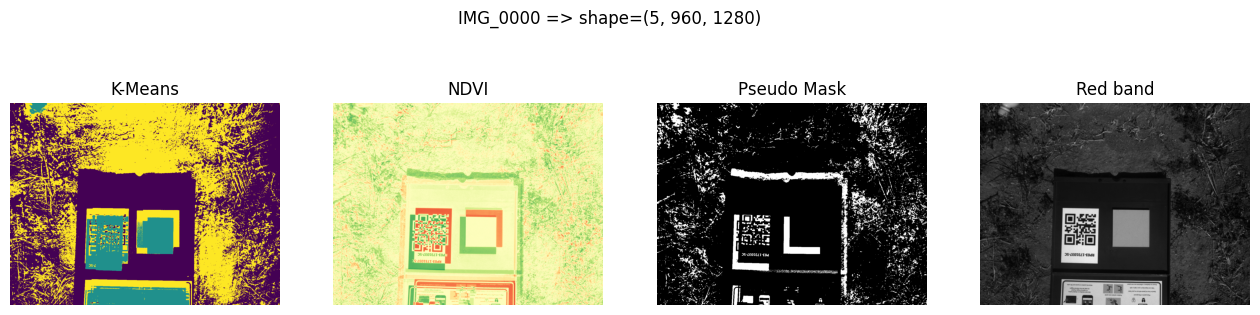

In [ ]:
###############################################################################
# STEP F: ACTUALLY RUN PROCESSING
###############################################################################
my_folder = os.path.join(output_dir, 'Agri', 'Maize',
                         'maize_season4_RededgeMultispectral_20200125_10m_flight1', '000')

processed_data = process_folder(my_folder, remove_borders=True, k_clusters=3, ndvi_thresh=0.3)
print("\nAll .tif files processed.")
print("Total samples:", len(processed_data))

# Plot just ONE sample
if len(processed_data) > 0:
    sample_id, big_stack_7, pseudo_mask = processed_data[0]
    cluster_map = big_stack_7[5]
    ndvi_map = big_stack_7[6]
    show_one_sample(big_stack_7[:5], cluster_map, ndvi_map, pseudo_mask, img_id=sample_id)

In [ ]:
###############################################################################
# STEP G: TRAIN/VAL SPLIT
###############################################################################
train_data, val_data = train_test_split(processed_data, test_size=0.3, random_state=42)
print(f"Train samples: {len(train_data)}, Val samples: {len(val_data)}")

Train samples: 211, Val samples: 91


In [ ]:
###############################################################################
# STEP H: ALBUMENTATIONS & DATASET
###############################################################################
def get_train_transforms():
    return A.Compose([
        A.RandomCrop(height=256, width=256),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
    ], additional_targets={'mask': 'mask'})

def get_val_transforms():
    return A.Compose([
        A.CenterCrop(height=256, width=256),
    ], additional_targets={'mask': 'mask'})

class WaterStressDataset(Dataset):
    def __init__(self, data_list, transform=None):
        super().__init__()
        self.data_list = data_list
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        img_id, big_stack, pseudo_mask = self.data_list[idx]
        # big_stack => (7,H,W)
        # mask => (H,W)
        big_stack_hw_c = np.transpose(big_stack, (1,2,0))  # (H,W,7)
        mask_hw = np.expand_dims(pseudo_mask, axis=-1)     # (H,W,1)

        if self.transform:
            augmented = self.transform(image=big_stack_hw_c, mask=mask_hw)
            big_stack_hw_c = augmented['image']
            mask_hw = augmented['mask']
        else:
            big_stack_hw_c = big_stack_hw_c.astype(np.float32)
            mask_hw = mask_hw.astype(np.float32)

        # back => (7,H,W), (1,H,W)
        big_stack_chw = np.transpose(big_stack_hw_c, (2,0,1))
        mask_chw = np.transpose(mask_hw, (2,0,1))

        # torch
        img_tensor = torch.from_numpy(big_stack_chw).float()
        mask_tensor = torch.from_numpy(mask_chw).float()
        return img_tensor, mask_tensor

train_transforms = get_train_transforms()
val_transforms   = get_val_transforms()

train_dataset = WaterStressDataset(train_data, transform=train_transforms)
val_dataset   = WaterStressDataset(val_data,   transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=2, shuffle=False, num_workers=0)

print("Dataloaders ready.")

Dataloaders ready.


In [ ]:
###############################################################################
# STEP I: RESNET + U-NET + CHANNEL-SPATIAL ATTENTION
###############################################################################
# 1) ChannelSpatialAttentionBlock
class ChannelSpatialAttentionBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        # Channel Attention
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels),
            nn.Sigmoid()
        )
        # Spatial Attention
        self.conv_spatial = nn.Conv2d(in_channels, 1, kernel_size=7, padding=3)
        self.sigmoid_spatial = nn.Sigmoid()

    def forward(self, x):
        b,c,h,w = x.size()
        # Channel
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b,c,1,1)
        x_ca = x * y

        # Spatial
        x_sa = self.conv_spatial(x_ca)
        x_sa = self.sigmoid_spatial(x_sa)
        out = x_ca * x_sa
        return out

# 2) ResNet-like encoder (simplified, to handle 7 input channels)
class ResNetEncoder(nn.Module):
    def __init__(self, in_channels=7):
        super().__init__()
        # initial input
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 64, blocks=2, stride=1)
        self.layer2 = self._make_layer(64, 128, blocks=2, stride=2)
        self.layer3 = self._make_layer(128,256, blocks=2, stride=2)
        self.layer4 = self._make_layer(256,512, blocks=2, stride=2)

    def _make_layer(self, in_ch, out_ch, blocks=2, stride=1):
        layers = []
        for i in range(blocks):
            s = stride if i==0 else 1
            layers.append(nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=s, padding=1))
            layers.append(nn.BatchNorm2d(out_ch))
            layers.append(nn.ReLU(inplace=True))
            in_ch = out_ch
        return nn.Sequential(*layers)

    def forward(self, x):
        x0 = self.initial(x)  # => (b,64,H/2,W/2)
        x1 = self.pool(x0)    # => (b,64,H/4,W/4)
        x2 = self.layer1(x1)  # => (b,64,H/4,W/4)
        x3 = self.layer2(x2)  # => (b,128,H/8,W/8)
        x4 = self.layer3(x3)  # => (b,256,H/16,W/16)
        x5 = self.layer4(x4)  # => (b,512,H/32,W/32)
        return [x0, x2, x3, x4, x5]

# 3) BasicBlock used in decoder
class BasicBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.bn1   = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bn2   = nn.BatchNorm2d(out_ch)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        return x

# 4) UNet decoder with CSAB
class UNetDecoder(nn.Module):
    def __init__(self, enc_chs=[64,64,128,256,512],
                 dec_chs=[256,128,64,64]):
        super().__init__()
        # up1 merges x5(512) w/ x4(256)
        self.up1 = self._up_block(enc_chs[-1], dec_chs[0], skip_in=enc_chs[-2])
        self.up2 = self._up_block(dec_chs[0], dec_chs[1], skip_in=enc_chs[-3])
        self.up3 = self._up_block(dec_chs[1], dec_chs[2], skip_in=enc_chs[-4])
        self.up4 = self._up_block(dec_chs[2], dec_chs[3], skip_in=enc_chs[-5])

        self.final = nn.Conv2d(dec_chs[-1], 1, kernel_size=1)

    def _up_block(self, in_ch, out_ch, skip_in):
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2),
            ChannelSpatialAttentionBlock(out_ch),
            BasicBlock(out_ch + skip_in, out_ch)
        )

    def forward(self, feats):
        x0, x2, x3, x4, x5 = feats
        # up1
        x = self.up1[0](x5)
        x = self.up1[1](x)
        x = torch.cat([x, x4], dim=1)
        x = self.up1[2](x)
        # up2
        x = self.up2[0](x)
        x = self.up2[1](x)
        x = torch.cat([x, x3], dim=1)
        x = self.up2[2](x)
        # up3
        x = self.up3[0](x)
        x = self.up3[1](x)
        x = torch.cat([x, x2], dim=1)
        x = self.up3[2](x)
        # up4
        x = self.up4[0](x)
        x = self.up4[1](x)
        x = torch.cat([x, x0], dim=1)
        x = self.up4[2](x)
        out = self.final(x)
        return out

# 5) Combined ResNet + U-Net + CSAB
class ResNetUNetCSAB(nn.Module):
    def __init__(self, in_channels=7):
        super().__init__()
        self.encoder = ResNetEncoder(in_channels=in_channels)
        self.decoder = UNetDecoder(enc_chs=[64,64,128,256,512],
                                   dec_chs=[256,128,64,64])
    def forward(self, x):
        feats = self.encoder(x)  # [x0, x2, x3, x4, x5]
        out = self.decoder(feats)
        return out

In [ ]:
###############################################################################
# STEP J: TRAINING CODE
###############################################################################
def dice_coefficient(pred, target, eps=1e-6):
    pred = torch.sigmoid(pred)
    pred_flat = pred.view(pred.size(0), -1)
    target_flat = target.view(target.size(0), -1)
    intersection = (pred_flat * target_flat).sum(dim=1)
    dice = (2.0 * intersection + eps) / (pred_flat.sum(dim=1) + target_flat.sum(dim=1) + eps)
    return dice.mean().item()

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    epoch_loss = 0.0
    epoch_dice = 0.0
    for images, masks in loader:
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_dice += dice_coefficient(logits.detach(), masks)

    epoch_loss /= len(loader)
    epoch_dice /= len(loader)
    return epoch_loss, epoch_dice

def validate_one_epoch(model, loader, criterion):
    model.eval()
    val_loss = 0.0
    val_dice = 0.0
    with torch.no_grad():
        for images, masks in loader:
            logits = model(images)
            loss = criterion(logits, masks)
            val_loss += loss.item()
            val_dice += dice_coefficient(logits, masks)

    val_loss /= len(loader)
    val_dice /= len(loader)
    return val_loss, val_dice



In [ ]:
###############################################################################
# STEP K: BUILD MODEL & TRAIN
###############################################################################
device = 'cpu'  # or 'cuda'
model = ResNetUNetCSAB(in_channels=7)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

num_epochs = 10
train_loss_history = []
val_loss_history   = []
train_dice_history = []
val_dice_history   = []

for epoch in range(num_epochs):
    train_loss, train_dice = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_dice = validate_one_epoch(model, val_loader, criterion)

    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_dice_history.append(train_dice)
    val_dice_history.append(val_dice)

    print(f"[Epoch {epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Dice: {train_dice:.4f} || "
          f"Val Loss: {val_loss:.4f}   | Val Dice: {val_dice:.4f}")

[Epoch 1/10] Train Loss: 0.4202 | Train Dice: 0.4771 || Val Loss: 0.4943   | Val Dice: 0.5227
[Epoch 2/10] Train Loss: 0.3029 | Train Dice: 0.5475 || Val Loss: 0.2613   | Val Dice: 0.5342
[Epoch 3/10] Train Loss: 0.2611 | Train Dice: 0.5780 || Val Loss: 0.2148   | Val Dice: 0.5875
[Epoch 4/10] Train Loss: 0.2335 | Train Dice: 0.6087 || Val Loss: 0.1936   | Val Dice: 0.6365
[Epoch 5/10] Train Loss: 0.2149 | Train Dice: 0.6369 || Val Loss: 0.1751   | Val Dice: 0.6422
[Epoch 6/10] Train Loss: 0.1977 | Train Dice: 0.6468 || Val Loss: 0.1734   | Val Dice: 0.6646
[Epoch 7/10] Train Loss: 0.1824 | Train Dice: 0.6650 || Val Loss: 0.1474   | Val Dice: 0.6884
[Epoch 8/10] Train Loss: 0.1779 | Train Dice: 0.6986 || Val Loss: 0.1365   | Val Dice: 0.7141
[Epoch 9/10] Train Loss: 0.1661 | Train Dice: 0.6981 || Val Loss: 0.1826   | Val Dice: 0.7030
[Epoch 10/10] Train Loss: 0.1632 | Train Dice: 0.7074 || Val Loss: 0.1105   | Val Dice: 0.7644


In [ ]:
class ResNetEncoder(nn.Module):
    def __init__(self, in_channels=7):
        super().__init__()
        # initial conv => stride=1 (changed from stride=2), so no immediate downsample
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=1, padding=3),  # stride=1
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        # This pool is your first halving => (H/2, W/2)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Then each layer may have stride=2 on the first block:
        self.layer1 = self._make_layer(64, 64, blocks=2, stride=1)  # no halving
        self.layer2 = self._make_layer(64, 128, blocks=2, stride=2) # second halving => /4
        self.layer3 = self._make_layer(128,256, blocks=2, stride=2) # third halving => /8
        self.layer4 = self._make_layer(256,512, blocks=2, stride=2) # fourth halving => /16

    def _make_layer(self, in_ch, out_ch, blocks=2, stride=1):
        layers = []
        for i in range(blocks):
            s = stride if i==0 else 1
            layers.append(nn.Conv2d(in_ch, out_ch, kernel_size=3,
                                    stride=s, padding=1))
            layers.append(nn.BatchNorm2d(out_ch))
            layers.append(nn.ReLU(inplace=True))
            in_ch = out_ch
        return nn.Sequential(*layers)

    def forward(self, x):
        # x => (b,7,H,W)
        x0 = self.initial(x)  # (b,64,H,W)  (no downsample here)
        x1 = self.pool(x0)    # (b,64,H/2,W/2)  (1st halving)
        x2 = self.layer1(x1)  # (b,64,H/2,W/2)  (no halving)
        x3 = self.layer2(x2)  # (b,128,H/4,W/4) (2nd)
        x4 = self.layer3(x3)  # (b,256,H/8,W/8) (3rd)
        x5 = self.layer4(x4)  # (b,512,H/16,W/16) (4th)

        # Return multi-scale features
        return [x0, x2, x3, x4, x5]


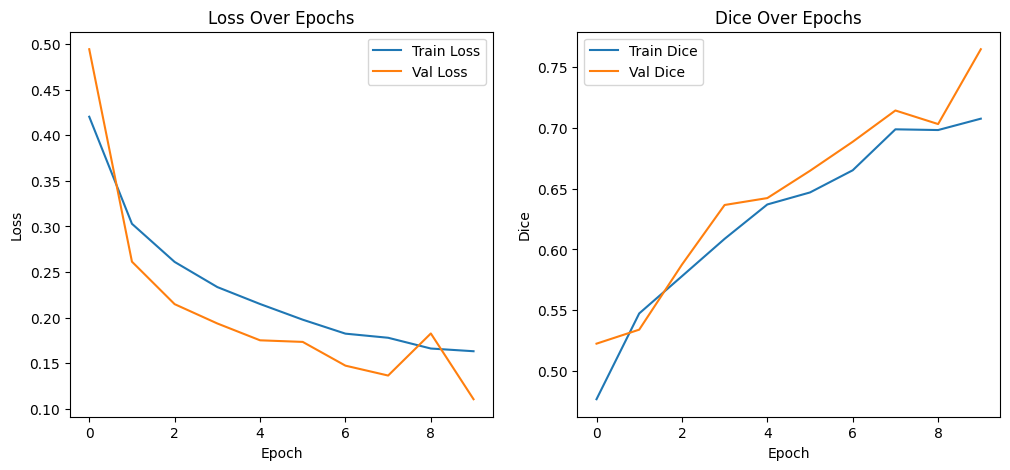

In [ ]:
##############################################################################
# STEP L: PLOT TRAINING CURVES
###############################################################################
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history,   label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_dice_history, label='Train Dice')
plt.plot(val_dice_history,   label='Val Dice')
plt.xlabel("Epoch")
plt.ylabel("Dice")
plt.title("Dice Over Epochs")
plt.legend()

plt.show()


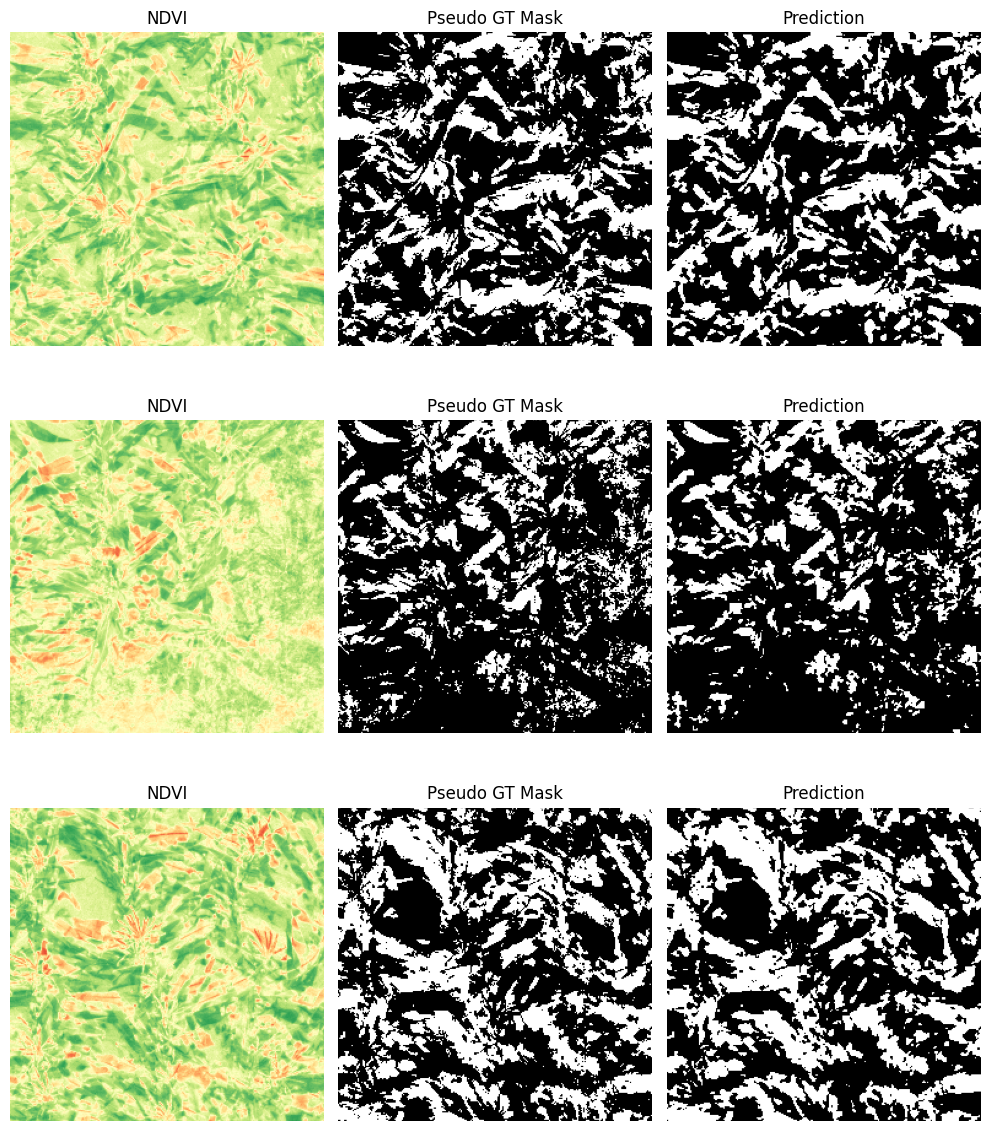

In [ ]:
###############################################################################
# STEP M: SAMPLE PREDICTIONS
###############################################################################
import random

model.eval()
if len(val_dataset) > 0:
    sample_indices = random.sample(range(len(val_dataset)), k=min(3, len(val_dataset)))
    plt.figure(figsize=(10, 4*len(sample_indices)))

    for i, idx in enumerate(sample_indices):
        images, masks = val_dataset[idx]  # shape: (7,H,W), (1,H,W)
        images = images.unsqueeze(0)      # => (1,7,H,W)

        with torch.no_grad():
            logits = model(images)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()

        mask_np = masks.squeeze().numpy()
        pred_np = preds.squeeze().numpy()
        ndvi_np = val_dataset[idx][0][6].numpy()  # channel 6 => NDVI

        plt.subplot(len(sample_indices), 3, i*3+1)
        plt.title("NDVI")
        plt.imshow(ndvi_np, cmap='RdYlGn', vmin=-1, vmax=1)
        plt.axis('off')

        plt.subplot(len(sample_indices), 3, i*3+2)
        plt.title("Pseudo GT Mask")
        plt.imshow(mask_np, cmap='gray', vmin=0, vmax=1)
        plt.axis('off')

        plt.subplot(len(sample_indices), 3, i*3+3)
        plt.title("Prediction")
        plt.imshow(pred_np, cmap='gray', vmin=0, vmax=1)
        plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No validation samples to visualize.")

In [ ]:
# 1) SPLIT into train, val, test
trainval_data, test_data = train_test_split(processed_data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(trainval_data, test_size=0.25, random_state=42)

print("Train:", len(train_data), "Val:", len(val_data), "Test:", len(test_data))



Train: 180 Val: 61 Test: 61


In [ ]:
# 2) DATASETS & LOADERS
train_dataset = WaterStressDataset(train_data, transform=get_train_transforms())
val_dataset   = WaterStressDataset(val_data,   transform=get_val_transforms())
test_dataset  = WaterStressDataset(test_data,  transform=get_test_transforms())



In [ ]:
def get_test_transforms():
    """
    Minimal or no transforms for test set.
    For example, just a center crop or maybe no crop at all.
    """
    import albumentations as A
    return A.Compose([
        A.CenterCrop(height=256, width=256),
        # or remove this entirely if you don't want any crop
    ], additional_targets={'mask': 'mask'})


In [ ]:
test_dataset = WaterStressDataset(test_data, transform=get_test_transforms())


In [ ]:
# 5) TEST
test_loss, test_dice = test_one_epoch(model, test_loader, criterion)
print(f"\nFINAL TEST RESULTS: Loss={test_loss:.4f}, Dice={test_dice:.4f}")


FINAL TEST RESULTS: Loss=0.1056, Dice=0.7457


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=2, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=2, shuffle=False, num_workers=0)

In [ ]:
def test_one_epoch(model, loader, criterion):
    model.eval()
    test_loss = 0.0
    test_dice = 0.0

    with torch.no_grad():
        for images, masks in loader:
            logits = model(images)
            loss = criterion(logits, masks)
            test_loss += loss.item()
            # Use the same dice_coefficient function you have
            test_dice += dice_coefficient(logits, masks)

    test_loss /= len(loader)
    test_dice /= len(loader)
    return test_loss, test_dice


In [ ]:
import matplotlib.pyplot as plt
import torch

def plot_sample_comparison(dataset, idx, model):
    """
    Plots a single sample:
     1) Approx RGB from channels [0..2]
     2) K-Means cluster map (channel 5)
     3) NDVI (channel 6)
     4) Pseudo-mask (from dataset)
     5) Predicted mask (from model)
    """
    model.eval()

    # dataset[idx] => (images, masks)
    # images => shape (7, H, W)
    # masks => shape (1, H, W) => pseudo-mask from NDVI threshold
    images, pseudo_mask = dataset[idx]

    # 1) Real image (approx) from first 3 channels: (3, H, W)
    #    If your band order is [Blue, Green, Red, RedEdge, NIR], then channels [0,1,2] => B,G,R
    #    Convert to (H, W, 3) for plotting
    approx_rgb = images[0:3].numpy().transpose(1, 2, 0)  # shape => (H,W,3)

    # Quick min-max normalization for display (optional)
    # (This step is not strictly required, but helps visualize if raw intensities are large.)
    # We'll do it per channel to avoid weird color distortions.
    for c in range(3):
        cmin = approx_rgb[..., c].min()
        cmax = approx_rgb[..., c].max()
        if cmax > cmin:  # avoid div by zero
            approx_rgb[..., c] = (approx_rgb[..., c] - cmin) / (cmax - cmin)

    # 2) K-Means cluster map => channel 5: shape => (H, W)
    cluster_map = images[5].numpy()

    # 3) NDVI => channel 6
    ndvi = images[6].numpy()

    # 4) Pseudo-mask => shape => (1, H, W), convert to (H,W)
    pseudo_mask_np = pseudo_mask.squeeze().numpy()

    # 5) Predicted mask => run a forward pass
    #    We must add a batch dimension => shape (1,7,H,W)
    images_batch = images.unsqueeze(0)
    with torch.no_grad():
        logits = model(images_batch)  # => shape (1,1,H,W)
        probs = torch.sigmoid(logits)
        pred_mask_bin = (probs > 0.5).float()  # threshold at 0.5

    pred_mask_np = pred_mask_bin.squeeze().cpu().numpy()  # shape (H,W)

    # === PLOT ===
    fig, axs = plt.subplots(1, 5, figsize=(18, 4))

    # (a) Approx RGB
    axs[0].imshow(approx_rgb)
    axs[0].set_title("Approx RGB")
    axs[0].axis('off')

    # (b) K-Means cluster
    axs[1].imshow(cluster_map, cmap='viridis')
    axs[1].set_title("K-Means Cluster")
    axs[1].axis('off')

    # (c) NDVI
    axs[2].imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
    axs[2].set_title("NDVI")
    axs[2].axis('off')

    # (d) Pseudo Mask
    axs[3].imshow(pseudo_mask_np, cmap='gray', vmin=0, vmax=1)
    axs[3].set_title("Pseudo Mask")
    axs[3].axis('off')

    # (e) Predicted Mask
    axs[4].imshow(pred_mask_np, cmap='gray', vmin=0, vmax=1)
    axs[4].set_title("Predicted Mask")
    axs[4].axis('off')

    plt.tight_layout()
    plt.show()


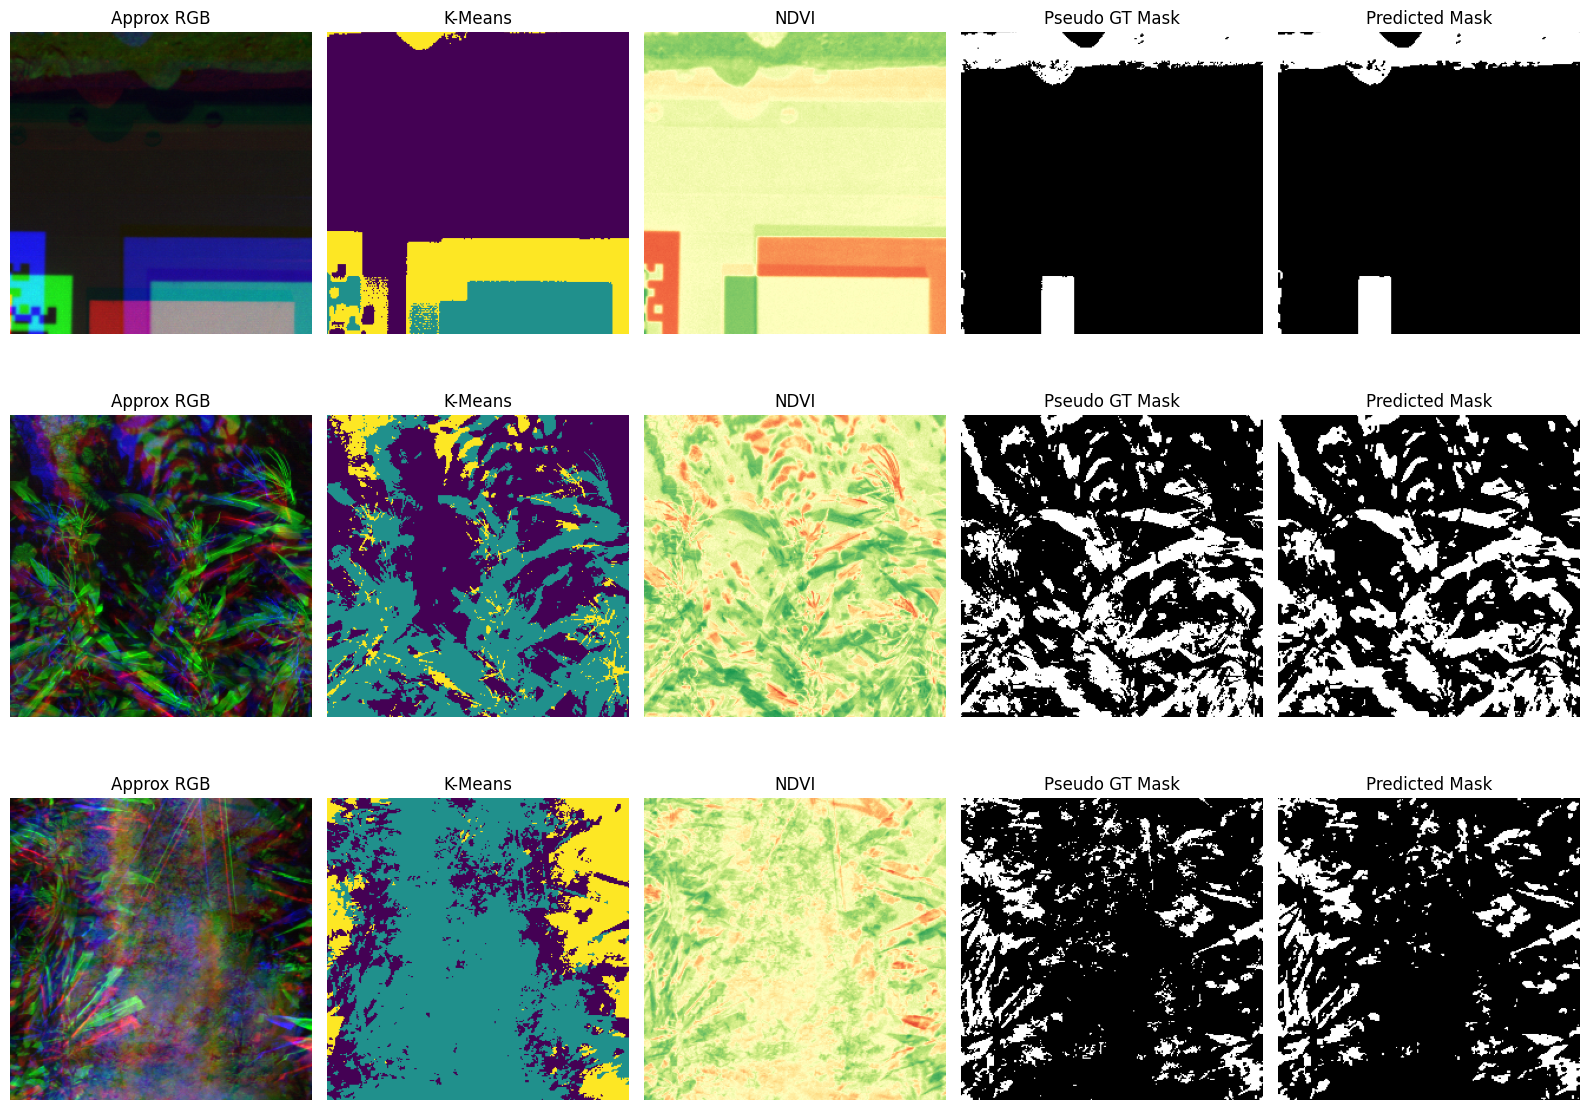

In [ ]:
###############################################################################
# STEP M: SAMPLE PREDICTIONS (5 columns: RGB, cluster, NDVI, pseudo GT, predicted)
###############################################################################
import random
import matplotlib.pyplot as plt

model.eval()
if len(val_dataset) > 0:
    # We'll display up to 3 random samples (or fewer if dataset is smaller)
    sample_indices = random.sample(range(len(val_dataset)), k=min(3, len(val_dataset)))

    # Prepare figure for (rows = #samples) x (cols = 5)
    plt.figure(figsize=(16, 4 * len(sample_indices)))

    for i, idx in enumerate(sample_indices):
        # 1) Grab data from dataset
        images, masks = val_dataset[idx]  # images: (7,H,W), masks: (1,H,W)
        # Expand batch dim => (1,7,H,W)
        images_batch = images.unsqueeze(0)

        # 2) Forward pass => predicted mask
        with torch.no_grad():
            logits = model(images_batch)       # (1,1,H,W)
            probs = torch.sigmoid(logits)      # (1,1,H,W)
            preds = (probs > 0.5).float()      # threshold -> binary

        # Convert arrays to numpy
        mask_np = masks.squeeze().numpy()       # shape: (H,W)
        pred_np = preds.squeeze().numpy()       # shape: (H,W)

        # We'll directly read from `images` for the other channels.
        # images => shape (7,H,W)
        # channels 0..4 => 5 bands, channel 5 => cluster, channel 6 => NDVI
        cluster_map = images[5].numpy()         # (H,W)
        ndvi_map    = images[6].numpy()         # (H,W)

        # Approx RGB from channels 0..2 (assuming [Blue,Green,Red])
        # shape => (3,H,W). Convert to (H,W,3).
        approx_rgb = images[0:3].numpy().transpose(1, 2, 0)  # (H,W,3)

        # Quick min-max normalization for display
        for c in range(3):
            cmin = approx_rgb[..., c].min()
            cmax = approx_rgb[..., c].max()
            if cmax > cmin:  # avoid divide-by-zero
                approx_rgb[..., c] = (approx_rgb[..., c] - cmin) / (cmax - cmin)

        # ===== PLOTTING =====
        # We'll plot 5 columns in row i
        # Indices: row * 5 + col_idx + 1
        row_offset = i * 5

        # (a) Approx RGB
        plt.subplot(len(sample_indices), 5, row_offset + 1)
        plt.title("Approx RGB")
        plt.imshow(approx_rgb)
        plt.axis('off')

        # (b) K-Means cluster map
        plt.subplot(len(sample_indices), 5, row_offset + 2)
        plt.title("K-Means")
        plt.imshow(cluster_map, cmap='viridis')
        plt.axis('off')

        # (c) NDVI
        plt.subplot(len(sample_indices), 5, row_offset + 3)
        plt.title("NDVI")
        plt.imshow(ndvi_map, cmap='RdYlGn', vmin=-1, vmax=1)
        plt.axis('off')

        # (d) Pseudo GT Mask
        plt.subplot(len(sample_indices), 5, row_offset + 4)
        plt.title("Pseudo GT Mask")
        plt.imshow(mask_np, cmap='gray', vmin=0, vmax=1)
        plt.axis('off')

        # (e) Predicted Mask
        plt.subplot(len(sample_indices), 5, row_offset + 5)
        plt.title("Predicted Mask")
        plt.imshow(pred_np, cmap='gray', vmin=0, vmax=1)
        plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No validation samples to visualize.")


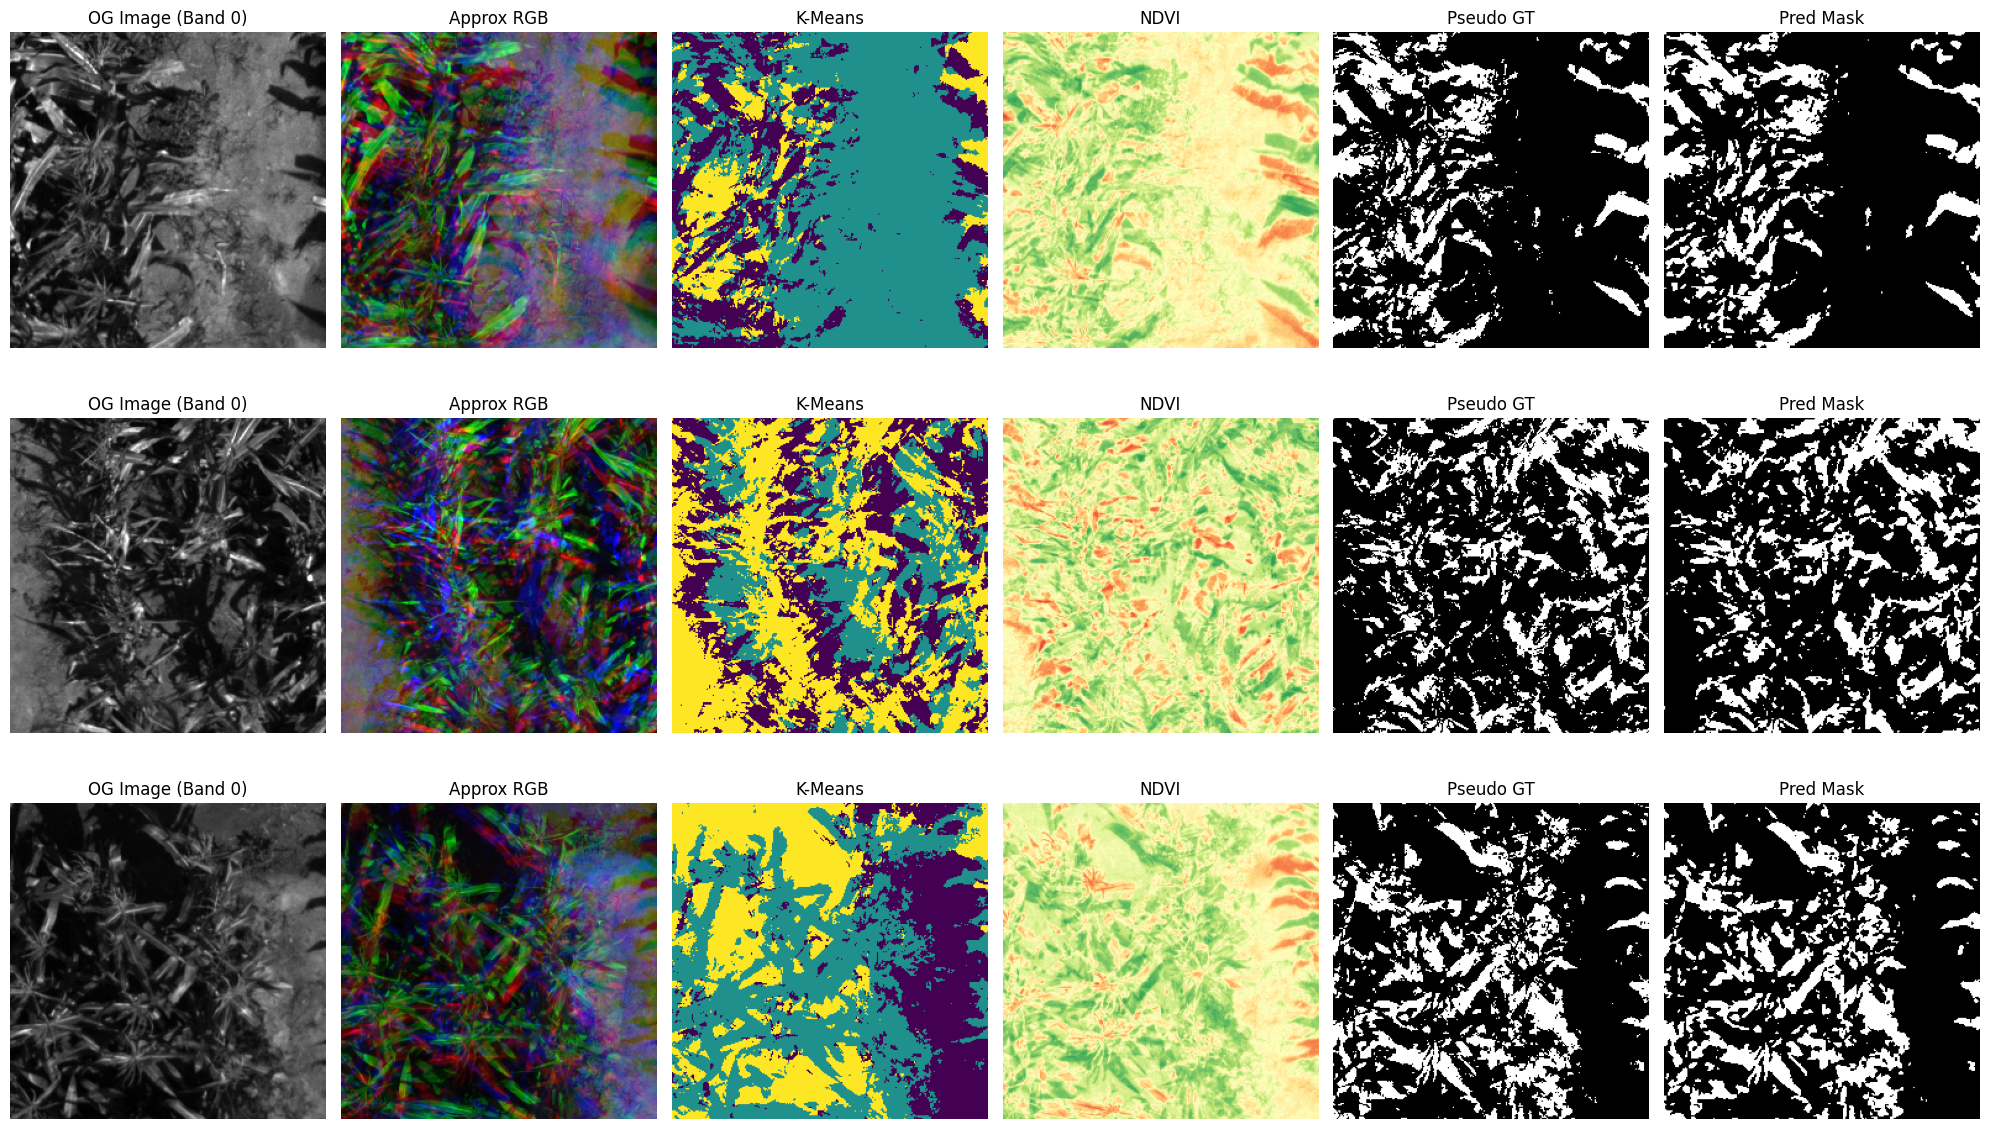

In [ ]:
###############################################################################
# STEP M: SAMPLE PREDICTIONS (6 columns: OG band, Approx RGB, cluster, NDVI, pseudo GT, predicted)
###############################################################################
import random
import matplotlib.pyplot as plt

model.eval()
if len(val_dataset) > 0:
    # We'll display up to 3 random samples (or fewer if the dataset is smaller)
    sample_indices = random.sample(range(len(val_dataset)), k=min(3, len(val_dataset)))

    # Prepare figure for (rows = #samples) x (cols = 6)
    plt.figure(figsize=(20, 4 * len(sample_indices)))

    for i, idx in enumerate(sample_indices):
        # 1) Grab data from dataset
        images, masks = val_dataset[idx]  # images: (7,H,W), masks: (1,H,W)
        # Expand batch dim => (1,7,H,W) for the forward pass
        images_batch = images.unsqueeze(0)

        # 2) Forward pass => predicted mask
        with torch.no_grad():
            logits = model(images_batch)      # (1,1,H,W)
            probs = torch.sigmoid(logits)     # (1,1,H,W)
            preds = (probs > 0.5).float()     # threshold -> binary

        # Convert arrays to numpy
        mask_np = masks.squeeze().numpy()       # shape: (H,W)
        pred_np = preds.squeeze().numpy()       # shape: (H,W)

        # Channels in images: 0..4 => 5 spectral, 5 => K-Means, 6 => NDVI
        # OG Image: let's pick band 0 as "OG" if you want just a single grayscale band
        og_image = images[0].numpy()  # shape: (H,W), band0 (e.g. Blue) or your choice

        # Approx RGB from channels 0..2 (assuming [Blue,Green,Red])
        # shape => (3,H,W). Convert to (H,W,3).
        approx_rgb = images[0:3].numpy().transpose(1, 2, 0)  # (H,W,3)

        # Quick min-max normalization for the approx RGB display
        for c in range(3):
            cmin = approx_rgb[..., c].min()
            cmax = approx_rgb[..., c].max()
            if cmax > cmin:  # avoid divide-by-zero
                approx_rgb[..., c] = (approx_rgb[..., c] - cmin) / (cmax - cmin)

        # K-Means cluster (channel 5)
        cluster_map = images[5].numpy()  # (H,W)

        # NDVI (channel 6)
        ndvi_map = images[6].numpy()

        # ===== PLOTTING =====
        # We'll plot 6 columns in row i
        # Indices: row * 6 + col_idx + 1
        row_offset = i * 6

        # (a) OG band (e.g. band 0)
        plt.subplot(len(sample_indices), 6, row_offset + 1)
        plt.title("OG Image (Band 0)")
        plt.imshow(og_image, cmap='gray')
        plt.axis('off')

        # (b) Approx RGB
        plt.subplot(len(sample_indices), 6, row_offset + 2)
        plt.title("Approx RGB")
        plt.imshow(approx_rgb)
        plt.axis('off')

        # (c) K-Means cluster
        plt.subplot(len(sample_indices), 6, row_offset + 3)
        plt.title("K-Means")
        plt.imshow(cluster_map, cmap='viridis')
        plt.axis('off')

        # (d) NDVI
        plt.subplot(len(sample_indices), 6, row_offset + 4)
        plt.title("NDVI")
        plt.imshow(ndvi_map, cmap='RdYlGn', vmin=-1, vmax=1)
        plt.axis('off')

        # (e) Pseudo GT Mask
        plt.subplot(len(sample_indices), 6, row_offset + 5)
        plt.title("Pseudo GT")
        plt.imshow(mask_np, cmap='gray', vmin=0, vmax=1)
        plt.axis('off')

        # (f) Predicted Mask
        plt.subplot(len(sample_indices), 6, row_offset + 6)
        plt.title("Pred Mask")
        plt.imshow(pred_np, cmap='gray', vmin=0, vmax=1)
        plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No validation samples to visualize.")


In [ ]:
###############################################################################
# STEP N: SAVE MODEL
###############################################################################
save_path = "resnet_unet_csab_water_stress.pth"
torch.save(model.state_dict(), save_path)
print("Model saved to:", save_path)

Model saved to: resnet_unet_csab_water_stress.pth
